In [1]:
# --- Project: KPI Anomaly Detector (v1 Notebook) ---
# Author: Dhwanil
# Goal: Explore KPI data, run anomaly detection, and save processed outputs.

import os
from pathlib import Path

# --- Path configuration ---
# Primary local folder (your Desktop)
LOCAL_DESKTOP_PATH = Path("/Users/dhwanil/Desktop/ONGOING PROJECTS/data for kpi")

# Fallbacks (for portability)
ALT_PATHS = [
    Path("../data/raw"),                   # repo data folder
    Path("~/Desktop/data for kpi").expanduser(),
]

# Find a valid data directory
if LOCAL_DESKTOP_PATH.exists():
    DATA_DIR = LOCAL_DESKTOP_PATH
else:
    for alt in ALT_PATHS:
        if alt.exists():
            DATA_DIR = alt
            break
    else:
        DATA_DIR = None

# --- Project folders ---
DATA_PROCESSED = Path("../data/processed")
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

GRAIN = "global"        # or "store"
RANDOM_SEED = 42

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.ensemble import IsolationForest
np.random.seed(RANDOM_SEED)
pd.set_option("display.max_columns", 100)

In [3]:
def load_local_data(data_dir: Path, grain="global"):
    """Load Store Sales dataset from local folder."""
    train_fp = data_dir / "train.csv"
    trans_fp = data_dir / "transactions.csv"
    oil_fp = data_dir / "oil.csv"
    hol_fp = data_dir / "holidays_events.csv"
    stores_fp = data_dir / "stores.csv"

    if not train_fp.exists():
        raise FileNotFoundError("train.csv not found in " + str(data_dir))

    # --- Load train ---
    use_cols = ["date", "store_nbr", "sales", "onpromotion"]
    df = pd.read_csv(train_fp, parse_dates=["date"], usecols=lambda x: x in use_cols)

    if grain == "global":
        df = df.groupby("date", as_index=False).agg(
            sales=("sales", "sum"),
            onpromotion=("onpromotion", "sum"),
        )

    # --- Transactions ---
    if trans_fp.exists():
        trans = pd.read_csv(trans_fp, parse_dates=["date"])
        if grain == "global":
            trans = trans.groupby("date", as_index=False)["transactions"].sum()
            df = df.merge(trans, on="date", how="left")
        else:
            df = df.merge(trans, on=["date", "store_nbr"], how="left")

    # --- Oil ---
    if oil_fp.exists():
        oil = pd.read_csv(oil_fp, parse_dates=["date"]).rename(columns={"dcoilwtico": "oil_price"})
        oil = oil.sort_values("date").set_index("date").ffill().reset_index()
        df = df.merge(oil, on="date", how="left")

    # --- Holidays ---
    if hol_fp.exists():
        hol = pd.read_csv(hol_fp, parse_dates=["date"])
        hol = hol[hol["transferred"] == False]
        hol["is_holiday"] = 1
        hol = hol.groupby("date", as_index=False)["is_holiday"].max()
        df = df.merge(hol, on="date", how="left")
        df["is_holiday"] = df["is_holiday"].fillna(0).astype(int)

    # --- Stores (optional) ---
    if stores_fp.exists() and grain != "global":
        stores = pd.read_csv(stores_fp)
        df = df.merge(stores, on="store_nbr", how="left")

    for c in ["transactions", "oil_price"]:
        if c in df.columns:
            df[c] = df[c].ffill().bfill()

    return df.sort_values(["date"] + (["store_nbr"] if grain != "global" else []))

def make_synthetic(days=730):
    """Fallback synthetic dataset."""
    dates = pd.date_range("2021-01-01", periods=days)
    sales = 200 + np.sin(np.linspace(0, 15, days)) * 20 + np.random.normal(0, 5, days)
    revenue = sales * (10 + np.random.normal(0, 0.5, days))
    cost = revenue * np.random.uniform(0.6, 0.8, days)
    engagement = np.random.normal(100, 10, days)
    oil_price = 60 + np.sin(np.linspace(0, 30, days)) * 5 + np.random.normal(0, 1, days)

    # anomalies
    idx = np.random.choice(len(dates), 12, replace=False)
    sales[idx] *= np.random.uniform(0.5, 1.6, len(idx))

    return pd.DataFrame({
        "date": dates,
        "sales": sales,
        "revenue": revenue,
        "cost": cost,
        "engagement": engagement,
        "transactions": (sales * np.random.uniform(0.8, 1.2)).astype(int),
        "oil_price": oil_price,
        "is_holiday": (pd.Series(dates).dt.dayofweek >= 5).astype(int)
    })

# --- Try local load ---
try:
    df_raw = load_local_data(DATA_DIR, grain=GRAIN)
    source = "local CSVs"
except Exception as e:
    print("⚠️ Local data load failed:", e, "\n→ Using synthetic data instead.")
    df_raw = make_synthetic()
    source = "synthetic"

df_raw = load_local_data(DATA_DIR, grain=GRAIN)
print("✅ Loaded:", df_raw.shape, "rows:", len(df_raw))
df_raw.head()

✅ Loaded: (1684, 6) rows: 1684


,date,sales,onpromotion,transactions,oil_price,is_holiday
0,2013-01-01,2511.618999,0,770.0,93.14,1
1,2013-01-02,496092.417944,0,93215.0,93.14,0
2,2013-01-03,361461.231124,0,78504.0,92.97,0
3,2013-01-04,354459.677093,0,78494.0,93.12,0
4,2013-01-05,477350.121229,0,93573.0,93.12,1


type(df_raw): <class 'pandas.core.frame.DataFrame'>


,date,sales,onpromotion,transactions,oil_price,is_holiday
count,1684,1.684000e+03,1684.00000,1684.000000,1684.000000,1684.000000
mean,2015-04-24 08:27:04.703088128,6.375564e+05,4638.13658,84133.253563,67.924899,0.144299
min,2013-01-01 00:00:00,2.511619e+03,0.00000,770.000000,26.190000,0.000000
25%,2014-02-26 18:00:00,4.427115e+05,0.00000,76265.250000,46.377500,0.000000
50%,2015-04-24 12:00:00,6.321889e+05,2300.00000,81569.500000,53.410000,0.000000
75%,2016-06-19 06:00:00,7.859455e+05,8397.25000,90781.000000,95.720000,0.000000
max,2017-08-15 00:00:00,1.463084e+06,26861.00000,171169.000000,110.620000,1.000000
std,NaN,2.344102e+05,5418.61702,12325.363730,25.676752,0.351497


🗓️ date range: 2013-01-01 00:00:00 → 2017-08-15 00:00:00


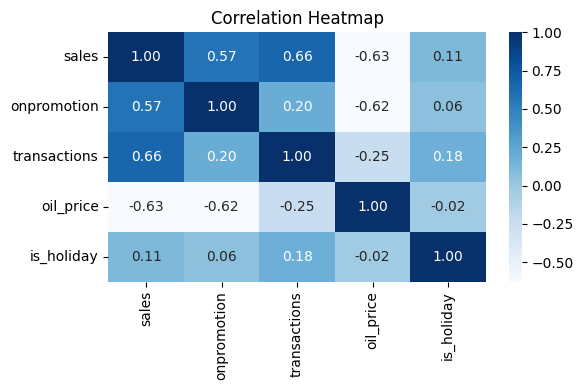

In [4]:
# --- EDA: summary + line chart + correlation (VS Code friendly) ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

# ensure VS Code renderer
pio.renderers.default = "vscode"

# sanity checks
print("type(df_raw):", type(df_raw))
if not isinstance(df_raw, pd.DataFrame):
    raise TypeError("df_raw is not a DataFrame. Re-run your load cell.")

# make sure 'date' is datetime if present
if "date" in df_raw.columns and not pd.api.types.is_datetime64_any_dtype(df_raw["date"]):
    df_raw["date"] = pd.to_datetime(df_raw["date"], errors="coerce")

# summary (works for any pandas version)
def safe_describe(obj):
    try:
        return obj.describe(datetime_is_numeric=True)
    except TypeError:
        return obj.describe()

display(safe_describe(df_raw))

# show date coverage
if "date" in df_raw.columns:
    print("🗓️ date range:", df_raw["date"].min(), "→", df_raw["date"].max())

# choose up to 4 numeric KPI columns (excluding common non-KPI fields)
exclude = {"date", "store_nbr", "state", "type", "cluster"}
num_cols = [c for c in df_raw.columns if c not in exclude and pd.api.types.is_numeric_dtype(df_raw[c])]
kpi_cols = num_cols[:4]

if "date" in df_raw.columns and kpi_cols:
    fig = px.line(
        df_raw.sort_values("date"),
        x="date",
        y=kpi_cols,
        title=f"KPI Overview ({', '.join(kpi_cols)})"
    )
    fig.show()
else:
    print("Skipping line chart (need a 'date' column and at least 1 numeric KPI).")

# correlation heatmap (requires >=2 numeric columns)
if len(num_cols) >= 2:
    plt.figure(figsize=(6, 4))
    sns.heatmap(df_raw[num_cols].corr(), annot=True, fmt=".2f", cmap="Blues")
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")

In [5]:
def add_time_features(df):
    df = df.copy()
    df["dow"] = pd.to_datetime(df["date"]).dt.dayofweek
    df["month"] = pd.to_datetime(df["date"]).dt.month
    df["is_weekend"] = (df["dow"] >= 5).astype(int)
    return df

def add_lag_roll(df, target="sales"):
    df = df.copy()
    df[f"{target}_lag_7"] = df[target].shift(7)
    df[f"{target}_lag_28"] = df[target].shift(28)
    df[f"{target}_rollmean_7"] = df[target].rolling(7).mean()
    df[f"{target}_rollstd_7"] = df[target].rolling(7).std()
    df[f"{target}_pct_change_1"] = df[target].pct_change(1)
    return df

df = add_time_features(df_raw)
df = add_lag_roll(df, "sales")
df_feat = df.dropna().reset_index(drop=True)
print("Processed shape:", df_feat.shape)
df_feat.head()

Processed shape: (1656, 14)


,date,sales,onpromotion,transactions,oil_price,is_holiday,dow,month,is_weekend,sales_lag_7,sales_lag_28,sales_rollmean_7,sales_rollstd_7,sales_pct_change_1
0,2013-01-29,264488.818076,0,68435.0,97.62,0,1,1,0,296214.728983,2511.618999,316383.951885,73839.837696,-0.073465
1,2013-01-30,281061.127052,0,70888.0,97.98,0,2,1,0,283258.453032,496092.417944,316070.048174,74008.606838,0.062658
2,2013-01-31,271254.217996,0,70268.0,97.65,0,3,1,0,247245.690995,361461.231124,319499.837745,70773.071168,-0.034892
3,2013-02-01,369402.055266,0,78302.0,97.46,0,4,2,0,290022.771930,354459.677093,330839.735365,71617.207631,0.361830
4,2013-02-02,518887.462705,0,97347.0,97.46,0,5,2,1,413799.767975,477350.121229,345852.263183,98044.288785,0.404669


In [6]:
def zscore_flags(series, thresh=3.0):
    z = (series - series.mean()) / series.std(ddof=0)
    return z, (z.abs() >= thresh)

def iqr_flags(series, k=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return (series < lo) | (series > hi), (lo, hi)

z, zmask = zscore_flags(df_feat["sales"])
imask, _ = iqr_flags(df_feat["sales"])

df_det = df_feat[["date", "sales"]].copy()
df_det["zscore"] = z
df_det["anom_zscore"] = zmask.astype(int)
df_det["anom_iqr"] = imask.astype(int)
df_det.head()

,date,sales,zscore,anom_zscore,anom_iqr
0,2013-01-29,264488.818076,-1.624939,0,0
1,2013-01-30,281061.127052,-1.553718,0,0
2,2013-01-31,271254.217996,-1.595864,0,0
3,2013-02-01,369402.055266,-1.174064,0,0
4,2013-02-02,518887.462705,-0.531637,0,0


In [7]:
features = [
    "sales","sales_lag_7","sales_rollmean_7","sales_rollstd_7",
    "onpromotion","transactions","oil_price","dow","month","is_weekend"
]
features = [f for f in features if f in df_feat.columns]

X = df_feat[features].fillna(0).values
iforest = IsolationForest(n_estimators=200, contamination=0.02, random_state=RANDOM_SEED)
scores = iforest.fit_predict(X)
decision = iforest.decision_function(X)

df_det["iforest_score"] = decision
df_det["anom_iforest"] = (scores == -1).astype(int)

In [8]:
try:
    from prophet import Prophet
    df_p = df_feat[["date","sales"]].rename(columns={"date":"ds","sales":"y"})
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode="additive")
    m.fit(df_p)
    fcst = m.predict(df_p)
    df_p["resid"] = df_p["y"] - fcst["yhat"]
    resid_std = df_p["resid"].std()
    df_p["anom_prophet"] = (df_p["resid"].abs() >= 3*resid_std).astype(int)
    df_det = df_det.merge(df_p.rename(columns={"ds":"date"})[["date","resid","anom_prophet"]],
                          on="date", how="left")
except Exception as e:
    print("Prophet not available:", e)

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

16:25:35 - cmdstanpy - INFO - Chain [1] start processing
16:25:35 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
def plot_anomalies(df, ts_col="sales", flag_col="anom_iforest"):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df["date"], y=df[ts_col], mode="lines", name=ts_col))
    if flag_col in df.columns:
        mask = df[flag_col] == 1
        fig.add_trace(go.Scatter(
            x=df.loc[mask, "date"],
            y=df.loc[mask, ts_col],
            mode="markers",
            name="Anomalies",
            marker=dict(color="red", size=8, symbol="circle-open")
        ))
    fig.update_layout(title=f"Anomaly Detection via {flag_col}", xaxis_title="Date", yaxis_title=ts_col)
    fig.show()

plot_anomalies(df_det, "sales", "anom_iforest")

In [10]:
flags = [c for c in df_det.columns if c.startswith("anom_")]
df_det["anom_any"] = df_det[flags].max(axis=1)
anom_table = df_det[df_det["anom_any"] == 1].sort_values("date")
display(anom_table.head(10))

,date,sales,zscore,anom_zscore,anom_iqr,iforest_score,anom_iforest,resid,anom_prophet,anom_any
328,2013-12-23,7.928653e+05,0.645809,0,0,-0.002317,1,154253.658505,0,1
336,2014-01-01,8.602065e+03,-2.724637,0,0,-0.003990,1,-536252.546576,1,1
337,2014-01-02,8.010112e+05,0.680817,0,0,0.052312,0,355759.083290,1,1
340,2014-01-05,9.496188e+05,1.319472,0,0,-0.004790,1,216373.105939,0,1
642,2014-11-03,9.731920e+05,1.420780,0,0,0.062421,0,411160.781832,1,1
692,2014-12-23,1.064978e+06,1.815239,0,0,0.004177,0,344885.753912,1,1
700,2015-01-01,1.277362e+04,-2.706709,0,0,-0.034817,1,-572937.519916,1,1
1006,2015-11-03,1.033439e+06,1.679698,0,0,0.095325,0,348967.057625,1,1
1052,2015-12-19,1.095524e+06,1.946512,0,0,-0.000018,1,7947.201417,0,1
1053,2015-12-20,1.175417e+06,2.289861,0,0,-0.010000,1,29348.399941,0,1
